In [106]:
import os
import zipfile
from tempfile import TemporaryDirectory
from inference import get_model
from PIL import Image
import roboflow
import pandas as pd
import supervision as sv
from inference import get_model
from PIL.ImageFile import ImageFile
import cv2
import seaborn as sns

In [107]:
worms_detected_count = pd.read_csv('./csv/worms_detected_count.csv')
worms_detected_count['date_time'] = pd.to_datetime(worms_detected_count['date_time'])
worms_detected_count

,image_name,num_worms,date_time,week_number
0,2024-08-26-00-00.jpg,0,2024-08-26 00:00:00,35
1,2024-08-26-00-10.jpg,0,2024-08-26 00:10:00,35
2,2024-08-26-00-20.jpg,0,2024-08-26 00:20:00,35
3,2024-08-26-00-30.jpg,0,2024-08-26 00:30:00,35
4,2024-08-26-00-40.jpg,0,2024-08-26 00:40:00,35
...,...,...,...,...
7895,2024-10-19-23-10.jpg,0,2024-10-19 23:10:00,42
7896,2024-10-19-23-20.jpg,0,2024-10-19 23:20:00,42
7897,2024-10-19-23-30.jpg,0,2024-10-19 23:30:00,42
7898,2024-10-19-23-40.jpg,0,2024-10-19 23:40:00,42


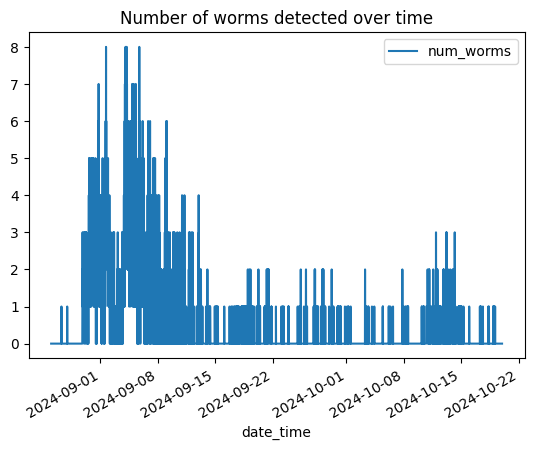

In [108]:
import matplotlib.pyplot as plt

worms_detected_count.plot(x='date_time', y='num_worms', kind='line', title='Number of worms detected over time')
plt.show()

In [109]:
worms_per_week = worms_detected_count.resample('W', on='date_time').agg({
    'num_worms': 'sum',
    'week_number': 'first'
})
worms_per_week.head()


,num_worms,week_number
date_time,,
2024-09-01,1069,35
2024-09-08,2013,36
2024-09-15,379,37
2024-09-22,227,38
2024-09-29,90,39


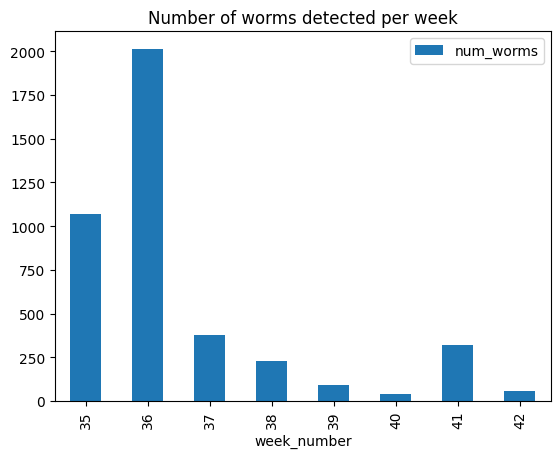

In [110]:
worms_per_week.plot(y='num_worms', x='week_number', kind='bar', title='Number of worms detected per week')
plt.show()

In [111]:
worms_per_hour = worms_detected_count.resample('h', on='date_time').agg({
    'num_worms': 'sum'
})

worms_per_hour

,num_worms
date_time,
2024-08-26 00:00:00,0
2024-08-26 01:00:00,0
2024-08-26 02:00:00,0
2024-08-26 03:00:00,0
2024-08-26 04:00:00,0
...,...
2024-10-19 19:00:00,0
2024-10-19 20:00:00,0
2024-10-19 21:00:00,0


### Load image data

In [112]:
# Load the CSV file into a DataFrame
image_data = pd.read_csv('./data/csv/image-data.csv', usecols=['time', 'mean_gray', 'count_pixels_lighter'])

# Convert the 'time' column to datetime format
image_data['time'] = pd.to_datetime(image_data['time'])

image_data

,time,mean_gray,count_pixels_lighter
0,2024-06-28 22:59:15.651947,25.383881,1129
1,2024-06-28 23:19:42.605933,25.088899,1434
2,2024-06-28 23:20:15.055077,25.257823,804
3,2024-06-28 23:21:15.022617,25.119673,166
4,2024-06-28 23:22:15.022551,25.385512,204
...,...,...,...
162299,2024-11-01 13:16:35.105059,29.154994,66741
162300,2024-11-01 13:17:35.303046,29.413673,68194
162301,2024-11-01 13:18:35.105863,29.393611,71454
162302,2024-11-01 13:19:35.303264,29.400202,73040


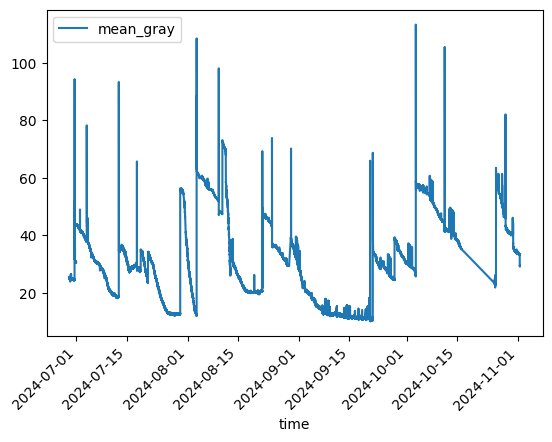

In [113]:
image_data.plot(x='time', y=['mean_gray'], kind='line')
plt.xticks(rotation=45)
plt.show()

In [114]:
# add column with diff of mean_gray from previous row
image_data['mean_gray_diff'] = image_data['mean_gray'].diff()
# add column where mean_gray_diff is made absolute
image_data['mean_gray_diff_abs'] = image_data['mean_gray_diff'].abs()
# do the same for count_pixels_lighter
image_data['count_pixels_lighter_diff'] = image_data['count_pixels_lighter'].diff()
# add column where count_pixels_lighter_diff is made absolute
image_data['count_pixels_lighter_diff_abs'] = image_data['count_pixels_lighter_diff'].abs()

In [115]:
image_data_by_hour = image_data.resample('h', on='time').agg({
    'mean_gray': 'mean',
    'mean_gray_diff': 'sum',
    'mean_gray_diff_abs': 'sum',
    'count_pixels_lighter': 'sum',
    'count_pixels_lighter_diff': 'sum',
    'count_pixels_lighter_diff_abs': 'sum',
})
image_data_by_hour.head()

,mean_gray,mean_gray_diff,mean_gray_diff_abs,count_pixels_lighter,count_pixels_lighter_diff,count_pixels_lighter_diff_abs
time,,,,,,
2024-06-28 22:00:00,25.383881,0.000000,0.000000,1129,0.0,0.0
2024-06-28 23:00:00,25.177406,-0.078762,4.508035,22663,52.0,15882.0
2024-06-29 00:00:00,25.052920,-0.150581,11.155930,58454,24.0,29028.0
2024-06-29 01:00:00,25.032347,-0.312523,8.702092,55251,-940.0,53574.0
2024-06-29 02:00:00,24.929339,0.161460,10.128279,45192,481.0,23847.0


### Explore correlation between worm count and image data variables

In [116]:
merged_data = pd.merge(image_data_by_hour, worms_per_hour, left_index=True, right_index=True)
merged_data.head()

,mean_gray,mean_gray_diff,mean_gray_diff_abs,count_pixels_lighter,count_pixels_lighter_diff,count_pixels_lighter_diff_abs,num_worms
2024-08-26 00:00:00,35.600633,-0.258340,5.655440,5320456,957.0,415361.0,0
2024-08-26 01:00:00,35.543194,0.068550,7.235255,5309710,6980.0,448750.0,0
2024-08-26 02:00:00,35.489796,-0.179038,6.460598,5358233,-4192.0,426434.0,0
2024-08-26 03:00:00,35.415091,0.081777,5.825216,5435760,4022.0,391188.0,0
2024-08-26 04:00:00,35.274749,-0.297788,7.358635,5509777,-8098.0,504208.0,0


<Axes: >

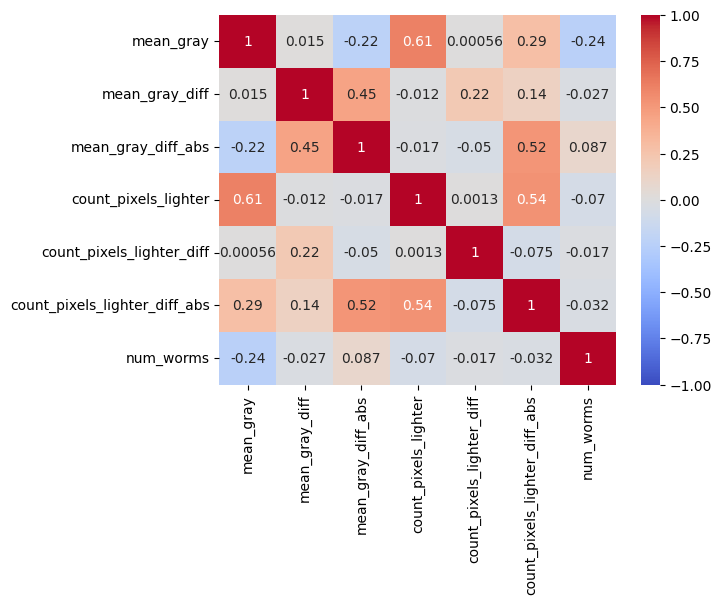

In [117]:
sns.heatmap(
    merged_data[[
        'mean_gray', 
        'mean_gray_diff',
        'mean_gray_diff_abs', 
        'count_pixels_lighter', 
        'count_pixels_lighter_diff',
        'count_pixels_lighter_diff_abs',
        'num_worms'
    ]].corr(),
    annot=True,
    vmin=-1,
    vmax=1,
    cmap='coolwarm'
)

<Axes: title={'center': 'Number of Worms Detected vs. Temperature'}, xlabel='count_pixels_lighter_diff_abs', ylabel='num_worms'>

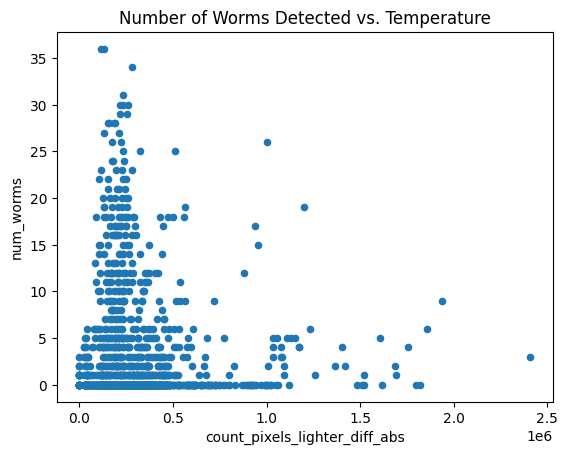

In [118]:
merged_data.plot(kind='scatter', x='count_pixels_lighter_diff_abs', y='num_worms', title='Number of Worms Detected vs. Temperature')

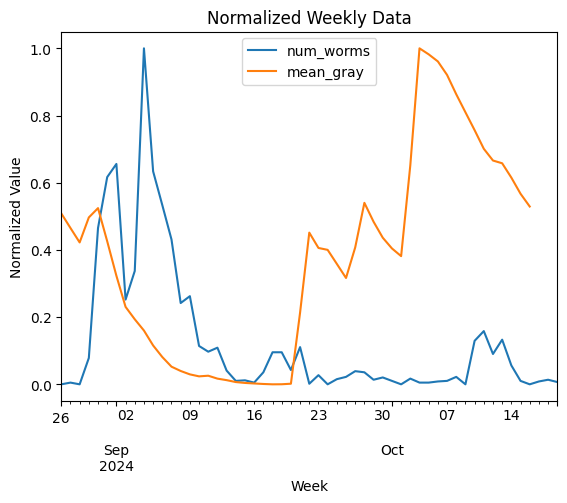

In [119]:
# Resample the data by week and calculate the mean
weekly_data = merged_data.resample('d').mean()

# Normalize the data
normalized_weekly_data = (weekly_data - weekly_data.min()) / (weekly_data.max() - weekly_data.min())

# Plot the normalized data
normalized_weekly_data[['num_worms', 'mean_gray']].plot(title='Normalized Weekly Data')
plt.xlabel('Week')
plt.ylabel('Normalized Value')
plt.show()